# Predicting the Next Hit Movie

**Objective**: Create a machine learning model to predict the next AAA movie

**Data Source**: [IMDB Dataset](https://datasets.imdbws.com/) (Accessed and downloaded on 6/19/2024)

**Data Files Used and Details**:
- **title.basics.tsv**: Contains the information about each title such as its its primary title, original title, type (movie, tv episode, etc.), start year, runtime, genres, and runtime in minutes.
    -  `tconst` (string) - alphanumeric unique identifier of the title
    - `titleType` (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
    - `primaryTitle` (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
    - `originalTitle` (string) - original title, in the original language
    - `isAdult` (boolean) - 0: non-adult title; 1: adult title
    - `startYear` (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
    - `endYear` (YYYY) – TV Series end year. ‘\N’ for all other title types
    - `runtimeMinutes` – primary runtime of the title, in minutes
    - `genres` (string array) – includes up to three genres associated with the title
- **title.crew.tsv**: Contains the information about the crew who did the title.
    - `tconst` (string) - alphanumeric unique identifier of the title
    - `directors` (array of nconsts) - director(s) of the given title
    - `writers` (array of nconsts) – writer(s) of the given title
- **title.ratings.tsv**: Contains the rating of each title.
    - `tconst` (string) - alphanumeric unique identifier of the title
    - `averageRating` – weighted average of all the individual user ratings
    - `numVotes` - number of votes the title has received

Since **title.episode.tsv**, focuses on different TV Series then we do not need it in our data. **title.akas.tsv** was also excluded since it only gives more information about the local title in the region.

After performing data cleaning and feature engineering, the final dataset was stored into `movies_df`. Below are the data cleaning and feature engineering steps and features of `movies_df`. 


**Data Cleaning Summary**:
- checking for null values 
- checking for duplicated data
- filtering for movies
- merging the different data frames
- removing columns we do not need
- double checking the data type of different columns
- replacing null values
- removing rows with missing values
- doing one-hot encoding for `genres`

**Feature Engineering**:
- adding `num_directors`
- adding `num_writers`
- adding `isAHit`

**Features of `movies_df`**:
- retained columns: `tconst`, `titleType`, `primaryTitle`, `originalTitle`, `isAdult`, `startYear`, `runtimeMinutes`, `averageRating`, `numVotes`, `directors`, `writers`
- new columns:
    - `num_directors` (integer): number of directors for the title
    - `num_writers` (integer): number of writers for the title
    - `genre_Action` (boolean): true if the genre is action, false otherwise
    - `genre_Adult` (boolean): true if the genre is adult, false otherwise
    - `genre_Adventure` (boolean): true if the genre is adventure, false otherwise
    - `genre_Animation` (boolean): true if the genre is animation, false otherwise
    - `genre_Comedy` (boolean): true if the genre is comedy, false otherwise
    - `genre_Crime` (boolean): true if the genre is crime, false otherwise
    - `genre_Biography` (boolean): true if the genre is biography, false otherwise
    - `genre_Documentary` (boolean): true if the genre is documentary, false otherwise
    - `genre_Drama` (boolean): true if the genre is drama, false otherwise
    - `genre_Family` (boolean): true if the genre is family, false otherwise
    - `genre_Fantasy` (boolean): true if the genre is fantasy, false otherwise
    - `genre_Film-Noir` (boolean): true if the genre is film-noir, false otherwise
    - `genre_Game-Show` (boolean): true if the genre is game-show, false otherwise
    - `genre_History` (boolean): true if the genre is history, false otherwise
    - `genre_Horror` (boolean): true if the genre is horror, false otherwise
    - `genre_Music` (boolean): true if the genre is music, false otherwise
    - `genre_Musical` (boolean): true if the genre is musical, false otherwise
    - `genre_Mystery` (boolean): true if the genre is mystery, false otherwise
    - `genre_News` (boolean): true if the genre is news, false otherwise
    - `genre_Reality-TV` (boolean): true if the genre is reality-tv, false otherwise
    - `genre_Romance` (boolean): true if the genre is romance, false otherwise
    - `genre_Sci-Fi` (boolean): true if the genre is sci-fi, false otherwise
    - `genre_Sport` (boolean): true if the genre is sport, false otherwise
    - `genre_Talk-Show` (boolean): true if the genre is talk-show, false otherwise
    - `genre_Thriller` (boolean): true if the genre is thriller, false otherwise
    - `genre_War` (boolean): true if the genre is war, false otherwise
    - `genre_Western` (boolean): true if the genre is western, false otherwise
    - `isAHit` (boolean): 1 if `averageRating` is greater than or equal to 7.0, otherwise it is 0

**Models Used**: Logistic Regression, XGBoost, and Random Forest

### Data Cleaning and Feature Engineering

In the code below we access the tsv files.

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import PartialDependenceDisplay

In [3]:
# Define the paths to your data files
data_folder = 'Data'

files = {
    'title_basics': os.path.join(data_folder, 'title.basics.tsv/title.basics.tsv'),
    'title_crew': os.path.join(data_folder, 'title.crew.tsv/title.crew.tsv'),
    'title_ratings': os.path.join(data_folder, 'title.ratings.tsv/title.ratings.tsv')
}

# Load the data into pandas dataframes
title_basics = pd.read_csv(files['title_basics'], sep='\t')
title_crew = pd.read_csv(files['title_crew'], sep='\t')
title_ratings = pd.read_csv(files['title_ratings'], sep='\t')

C:\Users\Ayisha\AppData\Local\Temp\ipykernel_14028\2813104754.py:11: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv(files['title_basics'], sep='\t')


In [4]:
# List of DataFrames
dataframes = {
    'title_basics': title_basics,
    'title_crew': title_crew,
    'title_ratings': title_ratings
}

For each dataset, we check the data type of each column, look for missing values, check the statistics, and duplicate values.

In [5]:
# Function to display basic information about the dataset
def profile_data(df, name):
    print(f"--- {name} ---")
    print(df.info())
    print(df.describe(include='all'))
    print("\nMissing values:\n", df.isnull().sum())
    print("\n")

# Profile each dataset
for name, df in dataframes.items():
    profile_data(df, name)


--- title_basics ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10858256 entries, 0 to 10858255
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 745.6+ MB
None
           tconst  titleType  primaryTitle originalTitle   isAdult startYear  \
count    10858256   10858256      10858237      10858237  10858256  10858256   
unique   10858256         11       4891439       4915175        43       152   
top     tt0000001  tvEpisode  Episode #1.1  Episode #1.1         0        \N   
freq            1    8314059         52080         52080  10445336   1411924   

         endYear runtimeMinutes    genres  
count   10858256       10858256  10857753  
unique        97     

In [6]:
# Function to check for duplicates by comparing entire rows
def check_row_duplicates(df):
    # Check for duplicate rows
    duplicates = df[df.duplicated(keep=False)]
    return duplicates

# Iterate through each DataFrame and check for duplicates
for name, df in dataframes.items():
    duplicates = check_row_duplicates(df)
    if not duplicates.empty:
        print(f"Duplicates in {name}:")
        print(duplicates)
    else:
        print(f"No duplicates in {name}")

No duplicates in title_basics
No duplicates in title_crew
No duplicates in title_ratings


Based on the documentation, the `title_basics` data frame would contain the titles which are movies and which aren't, so the first step would be to get the titles that are movies.

In [7]:
title_basics['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

Since there are two types of movies, they will both be considered in the `movies_df` dataframe below.

In [8]:
movies_df = title_basics[(title_basics['titleType'] == 'movie') | (title_basics['titleType'] == 'tvMovie')]

`movies_df` is then merged with `title_ratings` and `title_crew`. We then add more columns for the number of directors and writers the movie has. 

In [9]:
# Merge title_basics with title_ratings
movies_df = movies_df.merge(title_ratings, on='tconst', how='left')

In [10]:
# Merge movies_df with title_crew
movies_df = movies_df.merge(title_crew, on='tconst', how='left')

In [11]:
# Count the number of directors and writers
movies_df['num_directors'] = movies_df['directors'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)
movies_df['num_writers'] = movies_df['writers'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

<!-- In name_basics, we then add a column for the number of known titles the person is known for and the average of the ratings of the movies they have contributed to.
# Calculate the number of known titles
name_basics['num_known_titles'] = name_basics['knownForTitles'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Merge name_basics with title_ratings to calculate average rating of known titles
name_known_titles = name_basics[['nconst', 'knownForTitles']].copy()
name_known_titles = name_known_titles.dropna(subset=['knownForTitles'])
name_known_titles = name_known_titles.assign(knownForTitles=name_known_titles['knownForTitles'].str.split(',')).explode('knownForTitles')

# Merge with title_ratings
name_known_titles = name_known_titles.merge(title_ratings, left_on='knownForTitles', right_on='tconst', how='left')
name_known_titles_grouped = name_known_titles.groupby('nconst')['averageRating'].mean().reset_index()
name_known_titles_grouped.rename(columns={'averageRating': 'avg_known_title_rating'}, inplace=True)

# Merge back to name_basics
name_basics = name_basics.merge(name_known_titles_grouped, on='nconst', how='left')
name_basics['avg_known_title_rating'].fillna(0, inplace=True)
-->

Upon checking the `movies_df` dataframe below, we can still remove some columns like `endYear`.

In [12]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,num_directors,num_writers
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,5.4,212.0,nm0085156,nm0085156,1,1
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport",5.2,517.0,nm0714557,\N,1,1
2,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,4.4,17.0,nm0063413,"nm0063413,nm0657268,nm0675388",1,3
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography",6.0,910.0,nm0846879,nm0846879,1,1
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama,5.7,25.0,nm0141150,nm0141150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832113,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary,NaN,NaN,nm0652213,"nm0652213,nm10538576",1,2
832114,tt9916692,tvMovie,Teatroteka: Czlowiek bez twarzy,Teatroteka: Czlowiek bez twarzy,0,2015,\N,66,Drama,NaN,NaN,nm10538592,nm10538592,1,1
832115,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy,7.6,5.0,nm7764440,nm7933903,1,1
832116,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama,7.0,12.0,nm10538612,nm10538612,1,1


In [13]:
movies_df.drop(columns='endYear', inplace=True)

Afterwards, we save the new dataframe so that it is easier to load the data.

In [14]:
movies_df.to_csv('movies_df_06192024.tsv', sep='\t', index=False)

In [22]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}
movies_df = pd.read_csv('movies_df_06192024.tsv', sep='\t', dtype=dtype)

We want to take another look into what data type each column is and correct them if it is wrong.

In [23]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832118 entries, 0 to 832117
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          832118 non-null  object 
 1   titleType       832118 non-null  object 
 2   primaryTitle    832116 non-null  object 
 3   originalTitle   832116 non-null  object 
 4   isAdult         832118 non-null  int64  
 5   startYear       832118 non-null  object 
 6   runtimeMinutes  832118 non-null  object 
 7   genres          832118 non-null  object 
 8   averageRating   364864 non-null  float64
 9   numVotes        364864 non-null  float64
 10  directors       811854 non-null  object 
 11  writers         811854 non-null  object 
 12  num_directors   832118 non-null  int64  
 13  num_writers     832118 non-null  int64  
dtypes: float64(2), int64(3), object(9)
memory usage: 88.9+ MB


Since `runtimeMinutes` is an object type, we will convert it into an int64 type and replace its null values with 0.

In [24]:
movies_df.loc[movies_df['runtimeMinutes'] == '\\N', 'runtimeMinutes'] = 0
movies_df.loc[:, 'runtimeMinutes'] = movies_df['runtimeMinutes'].astype(int)

Since the documentation mentions that null values were placed as '\\N' we want to make sure that we can see which columns contain null values which is why we replace every instance of '\\N' with NaN.

In [25]:
movies_df.replace('\\N', np.nan, inplace=True)

We then look into the number of null values per column. Below we can see that the averageRating and numVotes column has a number of 467,254 null values, so we will proceed to remove those columns from our dataset to reduce bias and make sure that we still have a good representation of our data. Replacing these null values with the median value of the existing ratings or replacing them with 0 may skew the results and introduce bias.

In [26]:
null_values_per_column = movies_df.isnull().sum()
print(null_values_per_column)

tconst                 0
titleType              0
primaryTitle           2
originalTitle          2
isAdult                0
startYear         103469
runtimeMinutes         0
genres             89105
averageRating     467254
numVotes          467254
directors          94501
writers           205784
num_directors          0
num_writers            0
dtype: int64


In [28]:
movies_df = movies_df.dropna(subset=['averageRating', 'numVotes'])

We can observe below that `startYear`, `genres`, `directors`, and `writers` still contain null values. Below we will proceed to fill the null values for `startYear`, `directors`, and `writers` with 'Unknown'. `genres` will be cleaned later on. 

In [29]:
null_values_per_column = movies_df.isnull().sum()
print(null_values_per_column)

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear            40
runtimeMinutes        0
genres            11603
averageRating         0
numVotes              0
directors          6976
writers           48234
num_directors         0
num_writers           0
dtype: int64


In [30]:
movies_df.loc[:, 'startYear'] = movies_df['startYear'].fillna('Unknown')
movies_df.loc[:, 'directors'] = movies_df['directors'].fillna('Unknown')
movies_df.loc[:, 'writers'] = movies_df['writers'].fillna('Unknown')

In [31]:
null_values_per_column = movies_df.isnull().sum()
print(null_values_per_column)

tconst                0
titleType             0
primaryTitle          0
originalTitle         0
isAdult               0
startYear             0
runtimeMinutes        0
genres            11603
averageRating         0
numVotes              0
directors             0
writers               0
num_directors         0
num_writers           0
dtype: int64


Next, we do one-hot encoding for `genres`. One-hot encoding will allow us to focus on the different genres as separate features that may help us determine what type of genres help make a hit movie. In `data_exploded` we get `tconst` and `genres`. Afterwards, the `genres` column is transformed from a comma-separated string into a list of individual genres. The `explode` method is used to transform each element in the list-like `genres` column into a separate row, duplicating the `tconst` value for each genre.

In [32]:
# Split genres into multiple rows
# Separate the genres column and explode it
data_exploded = movies_df[['tconst', 'genres']].copy()
data_exploded['genres'] = data_exploded['genres'].str.split(',')
data_exploded = data_exploded.explode('genres')

`pd.get_dummies` creates a one-hot encoded DataFrame for the genres column, where each unique genre gets its own column with binary values (1 or 0) indicating the presence of that genre.

In [33]:
# One-hot encode the genres
genres_encoded = pd.get_dummies(data_exploded['genres'], prefix='genre')

The `tconst` column is joined with the one-hot encoded genre columns. The data is then grouped by `tconst`, and `max()` is used to combine rows with the same `tconst` value, ensuring each genre column contains a 1 if that genre is present for the movie. The `reset_index` method is used to turn the grouped DataFrame back into a standard DataFrame.

In [34]:
# Aggregate the one-hot encoded genres back to the original DataFrame
genre_data = data_exploded[['tconst']].join(genres_encoded).groupby('tconst').max().reset_index()

Below, the original genres column is dropped from `movies_df`. The one-hot encoded genre data (`genre_data`) is merged back into the original DataFrame (`movies_df`) based on the `tconst` column. The `how='left'` parameter ensures that all rows from `movies_df` are kept, and rows from `genre_data` are matched based on `tconst`.

In [35]:
# Merge the one-hot encoded genres with the original data
movies_df = movies_df.drop(columns=['genres'])
movies_df = movies_df.merge(genre_data, on='tconst', how='left')

In [36]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,directors,...,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,45,5.4,212.0,nm0085156,...,False,False,False,True,False,False,False,False,False,False
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,100,5.2,517.0,nm0714557,...,False,True,False,False,False,True,False,False,False,False
2,tt0000502,movie,Bohemios,Bohemios,0,1905,100,4.4,17.0,nm0063413,...,False,False,False,False,False,False,False,False,False,False
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,6.0,910.0,nm0846879,...,False,False,False,False,False,False,False,False,False,False
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,5.7,25.0,nm0141150,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364859,tt9916428,movie,The Secret of China,Hong xing zhao yao Zhong guo,0,2019,0,3.6,19.0,nm0910951,...,False,False,False,False,False,False,False,False,True,False
364860,tt9916460,tvMovie,Pink Taxi,Pink Taxi,0,2019,0,8.9,19.0,nm7048843,...,False,False,False,False,False,False,False,False,False,False
364861,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,123,8.3,9.0,nm4457074,...,False,False,False,False,False,False,False,False,False,False
364862,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,0,7.6,5.0,nm7764440,...,False,False,False,False,False,False,False,False,False,False


Below we normalize the data so that big values will not influence the outcome of the model.

In [38]:
# Features to scale
features_to_scale = ['runtimeMinutes', 'numVotes', 'num_directors', 'num_writers']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
movies_df.loc[:, features_to_scale] = scaler.fit_transform(movies_df[features_to_scale])

# Display to verify changes
movies_df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,directors,...,genre_Mystery,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western
0,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,-0.306890,5.4,-0.087373,nm0085156,...,False,False,False,True,False,False,False,False,False,False
1,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,0.141848,5.2,-0.078268,nm0714557,...,False,True,False,False,False,True,False,False,False,False
2,tt0000502,movie,Bohemios,Bohemios,0,1905,0.141848,4.4,-0.093195,nm0063413,...,False,False,False,False,False,False,False,False,False,False
3,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,-0.102918,6.0,-0.066535,nm0846879,...,False,False,False,False,False,False,False,False,False,False
4,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,0.060259,5.7,-0.092956,nm0141150,...,False,False,False,False,False,False,False,False,False,False


In [39]:
movies_df.to_csv('movies_df_06202024.tsv', sep='\t', index=False)

In [40]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}  # Replace 'column_name1', 'column_name2', etc., with actual column names
movies_df = pd.read_csv('movies_df_06202024.tsv', sep='\t', dtype=dtype)

Since we want to classify what movie would be the next hit based on ratings, we can assume that if a movie has a rating of 7 or above then it is a hit. Thus, we make a new column called `isAHit`.

In [41]:
movies_df['isAHit'] = (movies_df['averageRating'] >= 7.0).astype(int)

In [42]:
movies_df.to_csv('movies_df_06212024.tsv', sep='\t', index=False)

<!-- # import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calculate the correlation matrix
# correlation_matrix = movies_df[initial_feature_cols + [target_col]].corr()

# # Plot the heatmap of the correlation matrix
# plt.figure(figsize=(26, 10))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

# # Select features with high correlation to the target variable
# correlation_threshold = 0.1  
# relevant_features = correlation_matrix[target_col][abs(correlation_matrix[target_col]) > correlation_threshold].index.tolist()
# relevant_features.remove(target_col)

# print("Selected features based on correlation:", relevant_features)-->

### Model Training Preparation

## DO THE RANDOM SAMPLING HERE AND JUSTIFY NA ITS BC THE DATASET IS TOO BIG

In [4]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}
movies_df = pd.read_csv('movies_df_06212024.tsv', sep='\t', dtype=dtype)
movies_df_sample = movies_df.sample(n=50000, random_state=42)
movies_df_sample.to_csv('movies_df_sampled.tsv', sep='\t', index=False)

In [2]:
dtype = {'tconst': str, 'titleType': str, 'primaryTitle': str, 'originalTitle': str, 'startYear': str, 'directors': str, 'writers': str}
movies_df = pd.read_csv('movies_df_sampled.tsv', sep='\t', dtype=dtype)

In [3]:
# Define feature columns and target column
target_col = 'isAHit'
feature_cols = ['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers'] + [col for col in movies_df.columns if col.startswith('genre_')]

In [4]:
# Use the selected features for modeling
X = movies_df[feature_cols]
y = movies_df[target_col]

In [5]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Verify that the feature selection and preprocessing steps are correctly applied
print("Training features:", X_train.columns)
print("Testing features:", X_test.columns)

Training features: Index(['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers',
       'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Game-Show', 'genre_History', 'genre_Horror', 'genre_Music',
       'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Reality-TV',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Sport', 'genre_Talk-Show',
       'genre_Thriller', 'genre_War', 'genre_Western'],
      dtype='object')
Testing features: Index(['isAdult', 'runtimeMinutes', 'numVotes', 'num_directors', 'num_writers',
       'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation',
       'genre_Biography', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
       'genre_Drama', 'genre_Family', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Game-Show', 'genre_History', 'ge

In [7]:
movies_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,averageRating,numVotes,directors,...,genre_News,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,isAHit
0,tt3269194,movie,Varavu Nalla Uravu,Varavu Nalla Uravu,0,1990,0.460044,8.3,-0.092061,nm1127850,...,False,False,False,False,False,False,False,False,False,1
1,tt6315872,movie,Moomins and the Winter Wonderland,Muumien taikatalvi,0,2017,-0.005012,5.7,-0.079283,"nm6064135,nm4485543,nm1500863",...,False,False,False,False,False,False,False,False,False,0
2,tt4816906,movie,Naciye,Naciye,0,2015,-0.013171,5.3,-0.079014,nm2808904,...,False,False,False,False,False,False,True,False,False,0
3,tt0065425,movie,Sabata the Killer,Arriva Sabata!,0,1970,0.035783,5.5,-0.086538,nm0210322,...,False,False,False,False,False,False,False,False,True,0
4,tt5108932,movie,Five to Nine,Five to Nine,0,2015,0.060259,5.6,-0.093076,"nm4437163,nm7652108,nm3281183,nm4725263",...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,tt15215760,movie,Haterz,Haterz,0,2022,0.166325,7.4,-0.091464,nm7957324,...,False,False,False,False,False,False,False,False,False,1
49996,tt11960230,movie,Nick Mason's Saucerful of Secrets: Live at the...,Nick Mason's Saucerful of Secrets: Live at the...,0,2020,0.264231,8.1,-0.091523,nm2522100,...,False,False,False,False,False,False,False,False,False,1
49997,tt3148626,movie,"Case of Kyoko, Case of Shuichi",Kyôko to Shûichi no baai,0,2013,0.419250,6.2,-0.091941,nm0645760,...,False,False,False,False,False,False,False,False,False,0
49998,tt0479725,movie,Blue Moon,Blue Moon,0,2005,0.207119,7.9,-0.091284,nm0482774,...,False,False,True,False,False,False,False,False,False,1


### Logistic Regression

In [8]:
# Logistic Regression with hyperparameter tuning
log_reg = LogisticRegression(max_iter=10000, solver='saga')

Below we do hyperparameter tuning to find the best set of parameters for our model.

In [9]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Grid search 
grid_search_log_reg = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000, solver='saga'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [23]:
# Best parameters and score
print("Best parameters for Logistic Regression: ", grid_search_log_reg.best_params_)
print("Best cross-validation accuracy: ", grid_search_log_reg.best_score_)

# Predict and evaluate on the test set
y_pred_log_reg = grid_search_log_reg.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_log_reg))
print("Classification Report: \n", classification_report(y_test, y_pred_log_reg))

auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
print(f'AUC: {auc_log_reg}')

Best parameters for Logistic Regression:  {'C': 10, 'penalty': 'l1'}
Best cross-validation accuracy:  0.7409250000000001
Test Accuracy:  0.7358
Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.91      0.82      6840
           1       0.64      0.37      0.47      3160

    accuracy                           0.74     10000
   macro avg       0.70      0.64      0.65     10000
weighted avg       0.72      0.74      0.71     10000

AUC: 0.6365293508031683


In [11]:
# Confusion matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Confusion Matrix for Logistic Regression:\n", conf_matrix_log_reg)

# Extracting TP, FP, TN, FN from the confusion matrix
def extract_confusion_matrix_elements(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()
    return TN, FP, FN, TP

# Logistic Regression metrics
TN_log_reg, FP_log_reg, FN_log_reg, TP_log_reg = extract_confusion_matrix_elements(conf_matrix_log_reg)
print(f"Logistic Regression - TN: {TN_log_reg}, FP: {FP_log_reg}, FN: {FN_log_reg}, TP: {TP_log_reg}")

Confusion Matrix for Logistic Regression:
 [[6199  641]
 [2001 1159]]
Logistic Regression - TN: 6199, FP: 641, FN: 2001, TP: 1159


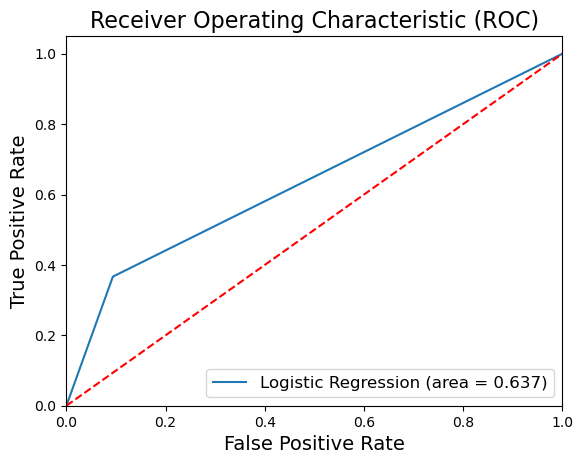

In [76]:
roc_auc = roc_auc_score(y_test, y_pred_log_reg)
fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'Logistic Regression (area = {roc_auc:.3f})')

# Plot the 45 degree line
plt.plot([0, 1], [0, 1], 'r--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

#### Model Understanding: Logistic Regression

In [12]:
# Extracting the best logistic regression model from GridSearchCV
best_log_reg = grid_search_log_reg.best_estimator_

# Coefficients and feature names
coefficients = best_log_reg.coef_[0]
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

# Sorting by the absolute value of the coefficient
importance_df = importance_df.sort_values(by='Absolute Coefficient', ascending=False)
print(importance_df)

              Feature  Coefficient  Absolute Coefficient
12  genre_Documentary     1.387890              1.387890
19       genre_Horror    -1.264133              1.264133
0             isAdult    -1.192309              1.192309
31      genre_Western    -1.041072              1.041072
17    genre_Game-Show     1.037793              1.037793
28    genre_Talk-Show     0.971720              0.971720
26       genre_Sci-Fi    -0.834110              0.834110
8     genre_Animation     0.686017              0.686017
20        genre_Music     0.651179              0.651179
5        genre_Action    -0.503330              0.503330
29     genre_Thriller    -0.465331              0.465331
7     genre_Adventure    -0.420610              0.420610
21      genre_Musical     0.324057              0.324057
10       genre_Comedy    -0.317740              0.317740
25      genre_Romance    -0.316715              0.316715
2            numVotes     0.306446              0.306446
22      genre_Mystery    -0.300

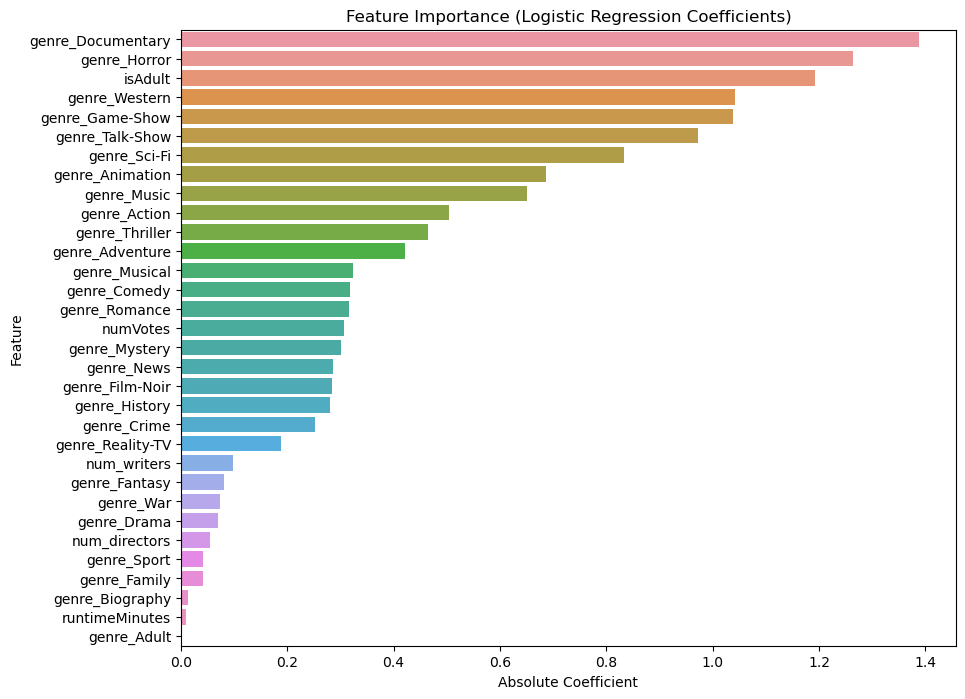

In [13]:
# Plotting the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Absolute Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

Key Features: The top features in terms of absolute coefficient values are genre_Documentary, genre_Horror, and genre_Western. These features have the strongest impact on the target variable.

Decision Making: Depending on the goal (e.g., improving a movie's chances for an award, optimizing marketing strategies), you can focus on the influential genres.

  0%|          | 0/10000 [00:00<?, ?it/s]

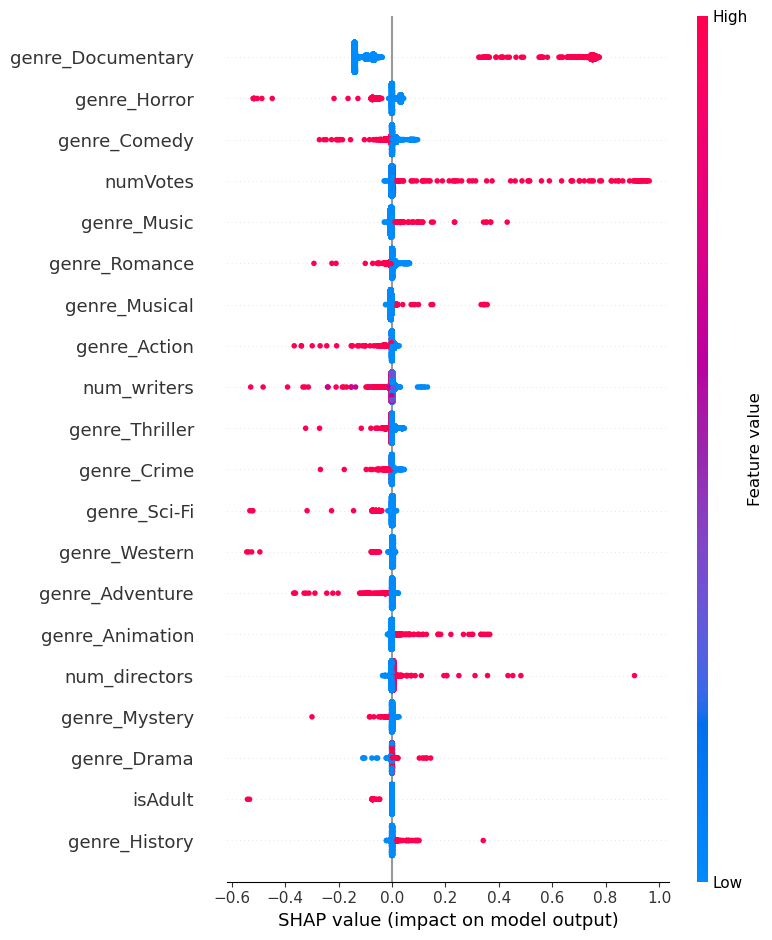

In [16]:
# Reduce the background data to a manageable size using random sampling
background_sample = shap.sample(X_train, 100)

# Initialize the SHAP explainer with the sampled background data
explainer = shap.KernelExplainer(best_log_reg.predict, background_sample)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

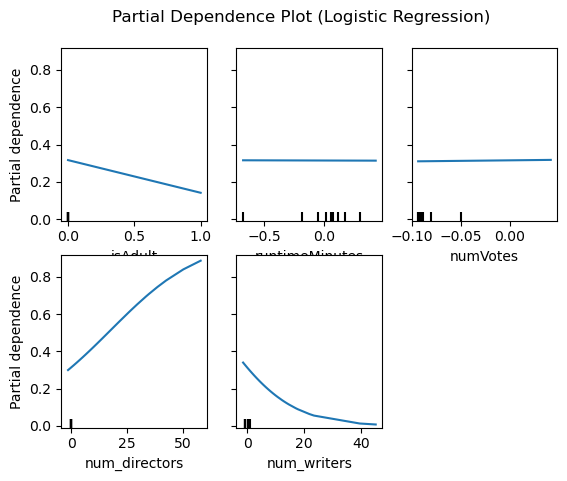

In [18]:
# Partial dependence plot for Logistic Regression
PartialDependenceDisplay.from_estimator(best_log_reg, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (Logistic Regression)')
plt.subplots_adjust(top=0.9)
plt.show()

### XGBoost

In [28]:
# XGBoost with hyperparameter tuning
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

# Define the parameter grid without the 'xgb__' prefix
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.3, 0.7]
}

# Grid search for XGBoost
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             scoring='accuracy')

In [29]:
# Best parameters and score
print("Best parameters for XGBoost: ", grid_search_xgb.best_params_)
print("Best cross-validation accuracy: ", grid_search_xgb.best_score_)

# Predict and evaluate on the test set
y_pred_xgb = grid_search_xgb.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Classification Report: \n", classification_report(y_test, y_pred_xgb))

auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print(f'AUC: {auc_xgb}')

Best parameters for XGBoost:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
Best cross-validation accuracy:  0.747475
Test Accuracy:  0.7436
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.89      0.83      6840
           1       0.64      0.43      0.52      3160

    accuracy                           0.74     10000
   macro avg       0.71      0.66      0.67     10000
weighted avg       0.73      0.74      0.73     10000

AUC: 0.6598526907987269


In [30]:
# Confusion matrix for Logistic Regression
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost:\n", conf_matrix_xgb)

# Logistic Regression metrics
TN_xgb, FP_xgb, FN_xgb, TP_xgb = extract_confusion_matrix_elements(conf_matrix_xgb)
print(f"Logistic Regression - TN: {TN_xgb}, FP: {FP_xgb}, FN: {FN_xgb}, TP: {TP_xgb}")

Confusion Matrix for XGBoost:
 [[6070  770]
 [1794 1366]]
Logistic Regression - TN: 6070, FP: 770, FN: 1794, TP: 1366


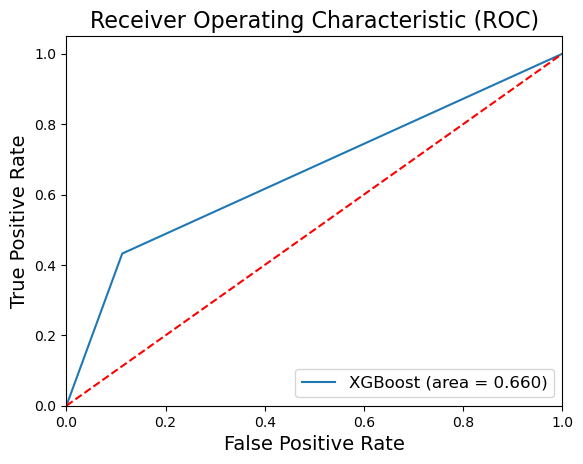

In [77]:
roc_auc = roc_auc_score(y_test, y_pred_xgb)
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'XGBoost (area = {roc_auc:.3f})')

# Plot the 45 degree line
plt.plot([0, 1], [0, 1], 'r--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

#### Understanding the Model: XGBoost

In [31]:
# Extracting the best XGBoost model from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_

# Feature importances
importances = best_xgb.feature_importances_
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

              Feature  Importance
12  genre_Documentary    0.562968
19       genre_Horror    0.069247
20        genre_Music    0.035629
2            numVotes    0.030711
5        genre_Action    0.028835
6         genre_Adult    0.028524
1      runtimeMinutes    0.026540
8     genre_Animation    0.024583
0             isAdult    0.018867
13        genre_Drama    0.017723
29     genre_Thriller    0.015970
31      genre_Western    0.014011
26       genre_Sci-Fi    0.013374
18      genre_History    0.011222
7     genre_Adventure    0.010250
25      genre_Romance    0.009185
10       genre_Comedy    0.009047
16    genre_Film-Noir    0.008767
11        genre_Crime    0.008572
9     genre_Biography    0.008314
15      genre_Fantasy    0.006683
27        genre_Sport    0.006374
14       genre_Family    0.006238
22      genre_Mystery    0.005764
30          genre_War    0.005346
23         genre_News    0.004605
4         num_writers    0.004456
21      genre_Musical    0.004236
3       num_di

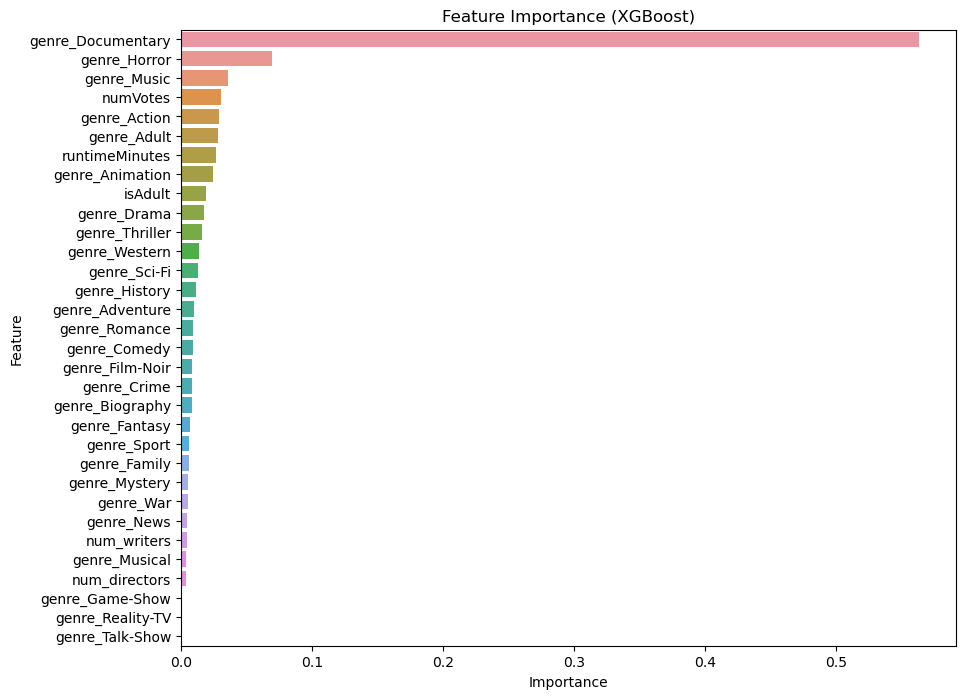

In [33]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (XGBoost)')
plt.show()

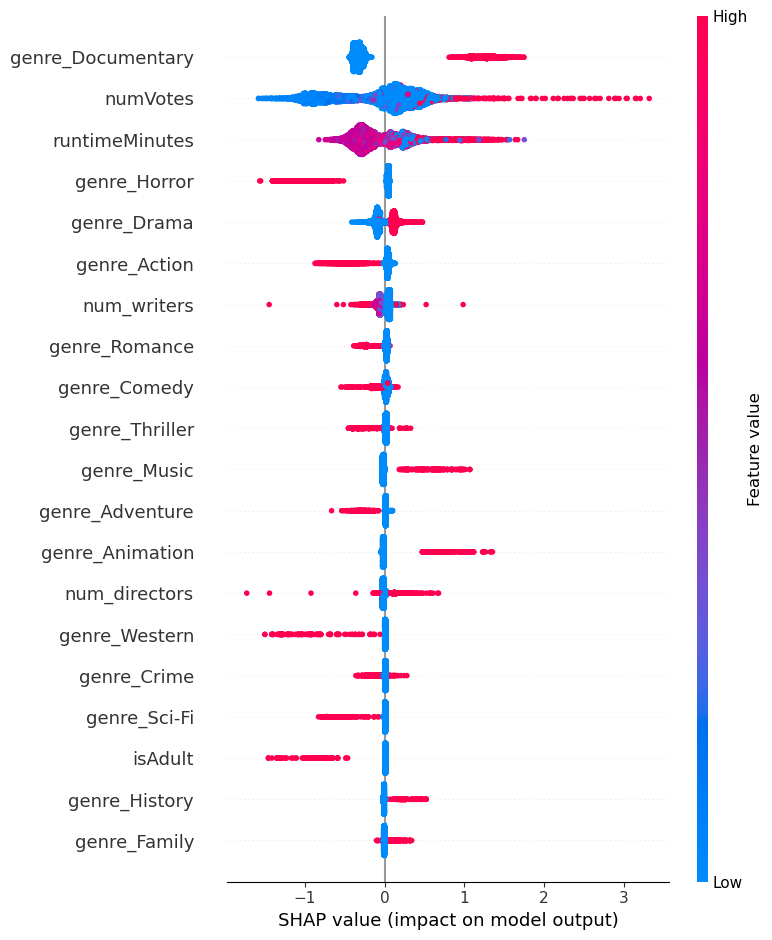

In [34]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_xgb)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

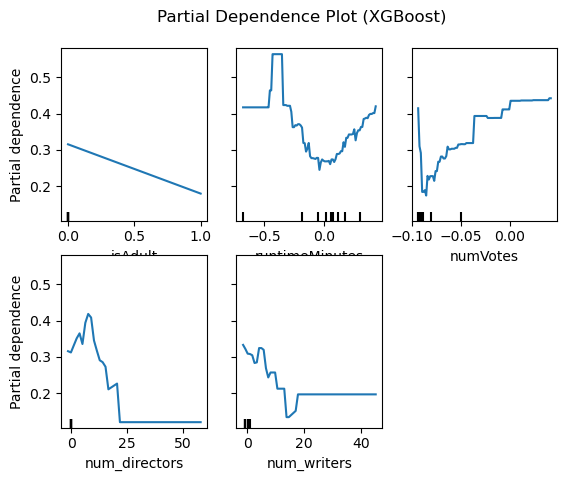

In [35]:
# Partial dependence plot for XGBoost
PartialDependenceDisplay.from_estimator(best_xgb, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (XGBoost)')
plt.subplots_adjust(top=0.9)  # Adjust top to fit title
plt.show()

### Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

In [38]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform Grid Search to find the best parameters
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [39]:
# Best parameters and score
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation accuracy: ", grid_search_rf.best_score_)

# Predict and evaluate on the test set
y_pred_rf = grid_search_rf.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Classification Report: \n", classification_report(y_test, y_pred_rf))

auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f'AUC: {auc_rf}')

Best parameters for Random Forest:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy:  0.7485249999999999
Test Accuracy:  0.744
Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      6840
           1       0.65      0.42      0.51      3160

    accuracy                           0.74     10000
   macro avg       0.71      0.66      0.67     10000
weighted avg       0.73      0.74      0.73     10000

AUC: 0.6558886668147161


In [40]:
# Confusion matrix for Logistic Regression
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Ranfom Forest:\n", conf_matrix_rf)

# Logistic Regression metrics
TN_rf, FP_rf, FN_rf, TP_rf = extract_confusion_matrix_elements(conf_matrix_rf)
print(f"Logistic Regression - TN: {TN_rf}, FP: {FP_rf}, FN: {FN_rf}, TP: {TP_rf}")

Confusion Matrix for Ranfom Forest:
 [[6124  716]
 [1844 1316]]
Logistic Regression - TN: 6124, FP: 716, FN: 1844, TP: 1316


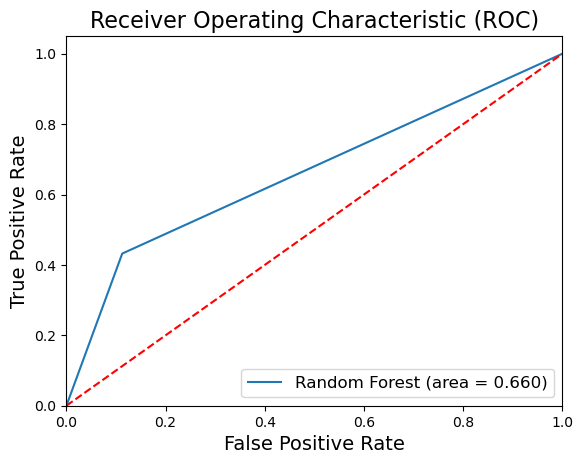

In [79]:
roc_auc = roc_auc_score(y_test, y_pred_xgb)
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb)

# Plot ROC curve
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc:.3f})')

# Plot the 45 degree line
plt.plot([0, 1], [0, 1], 'r--')

# Add labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()

#### Understanding the Model: Random Forests

In [41]:
# Extracting the best Random Forest model from GridSearchCV
best_rf = grid_search_rf.best_estimator_

# Feature importances
importances = best_rf.feature_importances_
feature_names = X.columns

# Creating a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorting by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

              Feature  Importance
12  genre_Documentary    0.255993
2            numVotes    0.227627
1      runtimeMinutes    0.184076
4         num_writers    0.043043
19       genre_Horror    0.028153
13        genre_Drama    0.027111
10       genre_Comedy    0.024043
3       num_directors    0.023378
5        genre_Action    0.020110
20        genre_Music    0.019263
29     genre_Thriller    0.014988
25      genre_Romance    0.012270
11        genre_Crime    0.012065
7     genre_Adventure    0.010691
18      genre_History    0.009978
14       genre_Family    0.009737
9     genre_Biography    0.009508
8     genre_Animation    0.009403
22      genre_Mystery    0.007882
15      genre_Fantasy    0.007789
21      genre_Musical    0.006921
30          genre_War    0.006717
31      genre_Western    0.006494
26       genre_Sci-Fi    0.006019
27        genre_Sport    0.004917
0             isAdult    0.004467
6         genre_Adult    0.003635
23         genre_News    0.001225
24   genre_Rea

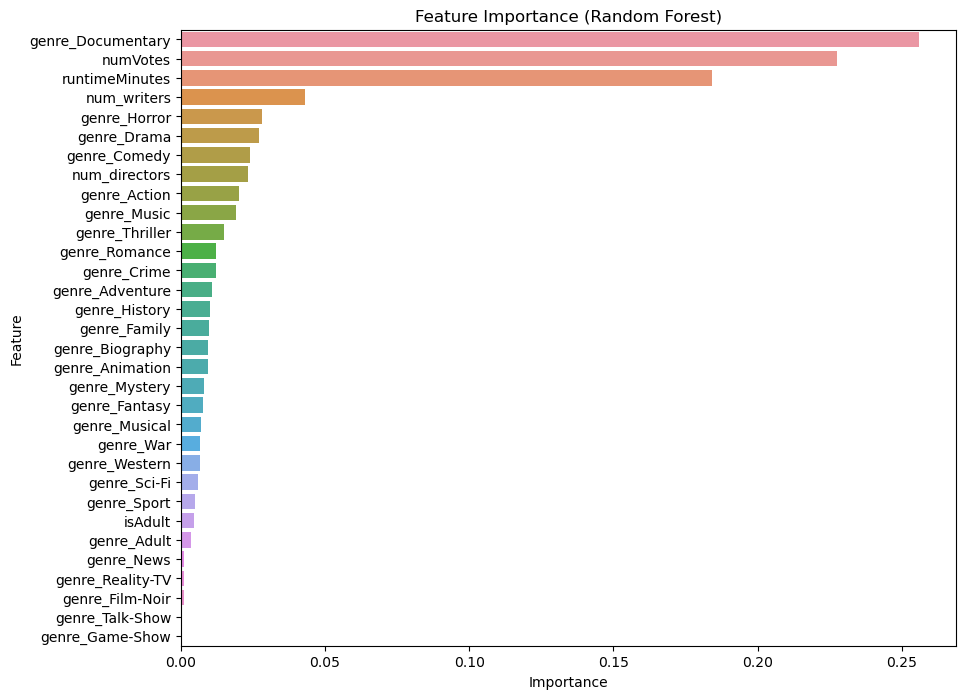

In [42]:
# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

In [52]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

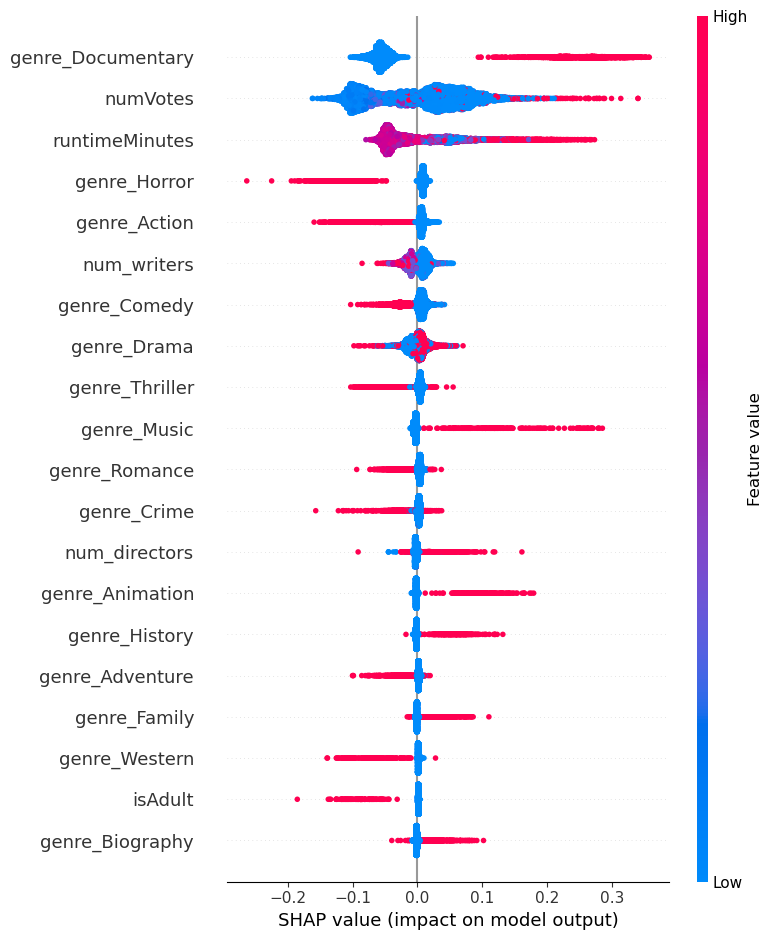

In [73]:
shap.summary_plot(shap_values[:, :, 1], X_test)

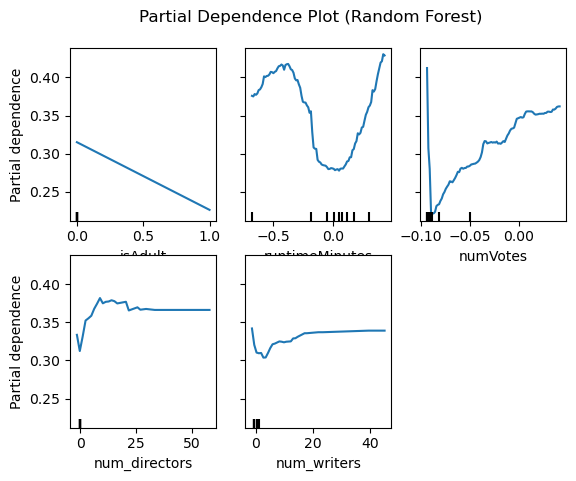

In [44]:
# Partial dependence plot for Random Forest
PartialDependenceDisplay.from_estimator(best_rf, X_train, features=[0, 1, 2, 3, 4])
plt.suptitle('Partial Dependence Plot (Random Forest)')
plt.subplots_adjust(top=0.9)  # Adjust top to fit title
plt.show()